# Social Graphs 2021 - Assignment 2
## Quick disclaimer
The assignment description could hint at not implementing some of the previous exercises, but just use the files already downloaded and processed. This seemed to make the exercises and explanations a little incoherrent, so we have included the code for the API-calls and other misc stuff. We have tried to collapse the cell blocks, so this is not annoying for the reader, but if they do appear, sorry for the inconvinience.

In [1]:
# Imports
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

import wordcloud
import nltk
import networkx as nx
import community

import re
import json
import urllib
import requests
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import seaborn as sns
import os
from tqdm import tqdm
from IPython.display import display

In [93]:
# Styles and data. If this cell block is not already hidden/minimized, feel free to do so, as it only contains the styles for the plots, 
# and the characters.csv in written form, as it allows for reruns of the code, if needed.
DTU_COLORS_HEX = dict(
    dtured      = "#990000",
    blue        = "#2F3EEA",
    brightgreen = "#1FD082",
    navyblue    = "#030F4F",
    yellow      = "#F6D04D",
    orange      = "#FC7634",
    pink        = "#F7BBB1",
    grey        = "#DADADA",
    red         = "#E83F48",
    green       = "#008835",
    purple      = "#79238E"
)

def hex_to_rgb(hex: str):
    hex = hex.replace("#", "")
    return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))

DTU_COLORS_RGB = [hex_to_rgb(x) for x in DTU_COLORS_HEX.values()]
dtu_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("dtu_colors", DTU_COLORS_RGB, N=100)

cmap = sns.color_palette("Spectral", as_cmap=True)
colors = list(DTU_COLORS_HEX.values())

sns.set()
sns.set_palette("Spectral")

big_plot = dict(
    figsize     = (20, 20),
)

default = dict(
    figsize     = (20, 5),
)

# 0. Building the network
As this process is a two step of finding names, and then their pages, we have shuffled the explanation of strategy and regular expressions

## Strategy for extracting hyperlinks from the wiki-pages
### Downloading
First we download the three wiki pages containing the ally, enemy and boss characters. From this we use a regular expression to find all character names.
### Regex
First the boss page has an edge case, where the location of the boss is included in the same format, as the name of the boss. To remove this, we use ```{{Small.*?''}}``` to find the locations and remove them.

When these are removed we use ```({{Term\|BotW\|(.*?)\|link[\|]*.*?}})``` to find the names of each character. All names follow the same convention of `{{Term|BotW|NAME OF CHARACTER|link|MAYBE MORE STUFF}}` occasionally followed by further information. This is solved by using `*.*?` which lazily finds additional terms. `*?` makes sure, that this is only done until the following character `}` is found.

## Strategy for finding gender and race
As we already have the character pages, we do a regex expression for gender, and for race.

* Race: `{{Infobox.*?\|(?:race=|species=)\s(.*?)(?:\n|<ref).*?(?:\|gender=\s`**(.*?)**`(?:\n|<ref)|).*?}}`. 

For each character page we use this expression. All metainformation, including the races, is contained in an Infobox, explaining the beginning and end of the expressions. We use capture groups to allow for or-statements signified by `(|)` the |-symbol, as this cannot be written outside of a capture group. As whether the keyword is `race` or `species` is not important `(?:)` is used, to make the capture group not return anything. The same convention is followed throughout the expression, to include different types of definitions. Lastly the small group `(.*?)` is used to find the race of the character. Characters might have multiple races, in which case only the first is chosen.

* Gender: `.*(Male|Female).*`. 

Genders are only included inside of infoboxes, which we found in the previous expression. Using the extraction from the previous expression this expression is now used. This expression is only run for these infoboxes. The expression is only used on these, searching for males or females, where the `|`-symbol signifies an or-statement. For genders outside of male or female, the gender `unknown` is assigned to the character. 

From here we do an API-call using the character names to get each characters content. Then we use the regular the same set of regular expressions for each character extracting the links to other characters.

## Strategy for extracting links to characters
Curly and square bracket

# 1. Network visualization and basic stats
## Preliminary
The code below finds the character links using the regex expressions previosly discussed, and extracts the giant component using networkx.

In [3]:
df = pd.read_csv("Characters.csv")

import networkx as nx

G = nx.DiGraph()
for _, (name, role, race, gender) in df.iterrows():
    G.add_node(name, role=role, race=race, gender=gender)

# Expressions
brackets_pattern = r'\[\[(.*?)(?:\|.*?|\#.*?)?\]\]'
curly_pattern =    r'{{(?:Term|Plural)\|.*?\|(.*?)(?:\|.*?)?}}'

for name in df.Name:
    description = open(f"././Characters/{name}.txt", "r", encoding="utf-8").read()
    links = []
    links.extend(re.findall(brackets_pattern, description))
    links.extend(re.findall(curly_pattern, description))
    for link in links:
        if link in df.Name.values and link != name:
            G.add_edge(name, link)

GCC = G.subgraph(max(nx.weakly_connected_components(G), key=len))

print(f"Number of nodes in network: \t {GCC.number_of_nodes()}")
print(f"Number of links🔗: \t\t {GCC.number_of_edges()}")

sorted_in  = sorted(GCC.nodes, key=GCC.in_degree, reverse=True)
sorted_out = sorted(GCC.nodes, key=GCC.out_degree, reverse=True)
sorted_tot = sorted(GCC.nodes, key=GCC.degree, reverse=True)

print(f"Most connected in:\t {sorted_in[0]}\n\tin👈:\t{GCC.in_degree(sorted_in[0])}\n\tout👉:\t{GCC.out_degree(sorted_in[0])}")
print(f"Most connected out:\t {sorted_out[0]}\n\tin👈:\t{GCC.in_degree(sorted_out[0])}\n\tout👉:\t{GCC.out_degree(sorted_out[0])}")
print(f"Most connected overall:\t {sorted_tot[0]}\n\tin👈:\t{GCC.in_degree(sorted_tot[0])}\n\tout👉:\t{GCC.out_degree(sorted_tot[0])}")

allies = df[df.Role=="Ally"].Name.to_list()
enemies = df[df.Role.isin(["Enemy", "Boss"])].Name.to_list()

sorted_allies = list(filter(lambda x: x in allies, sorted_tot))
sorted_enemies = list(filter(lambda x: x in enemies, sorted_tot))

# Seems a bit long to show same result as above for all allies and enemies,
# so here we only look at total degree
print("Most connected allies (name, in, out) ✌")
print("\t"+"\n\t".join([", ".join([str(x), str(GCC.in_degree(x)), str(GCC.out_degree(x))]) for x in sorted_allies[:5]]))
print("Most connected enemies (name, in, out) 😈")
print("\t"+"\n\t".join([", ".join([str(x), str(GCC.in_degree(x)), str(GCC.out_degree(x))]) for x in sorted_enemies[:5]]))


Number of nodes in network: 	 520
Number of links🔗: 		 1741
Most connected in:	 Link
	in👈:	391
	out👉:	9
Most connected out:	 Traysi
	in👈:	2
	out👉:	14
Most connected overall:	 Link
	in👈:	391
	out👉:	9
Most connected allies (name, in, out) ✌
	Link, 391, 9
	Hylia, 67, 3
	Princess Zelda, 32, 7
	Riju, 23, 5
	Purah, 17, 8
Most connected enemies (name, in, out) 😈
	Calamity Ganon, 101, 8
	Bokoblin, 20, 10
	Lizalfos, 11, 13
	Moblin, 10, 12
	Stalizalfos, 9, 12


## Stats
Number of nodes, and links can be seen above.

## Most connected character.
Link being the most overall connected character is not suprising, as he is the main character of the franchise. It did however suprise us a bit, that he is not the most out-wards connected character, and Traysi is instead. After reading about her, it makes sense, as she has a quest where Link has to talk to different people, and all of these people are all linked on her page, which is of course not mentioned on Links page as it is quite a small quest, but all of it is mentioned on her page, as that is most of her role in the game.

## Mostly connected allies and enemies
For the allies it is more or less what was expected, as all the characters that appear in the top 5 are main characters. For the enemies its a bit confusing, as all other characters than Calamity Ganon are not characters, but instead generic enemies. It does however make sense, that they are in the top 5, as they are commonly occurring.

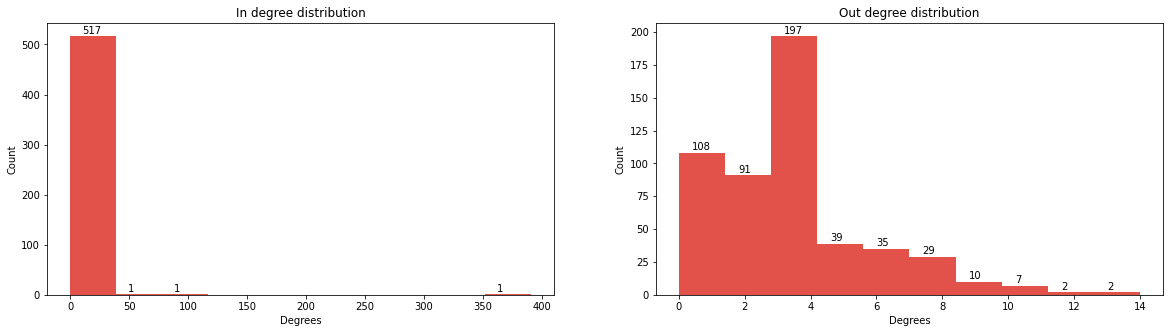

In [4]:
fig, (in_ax, out_ax) = plt.subplots(1, 2, **default)
in_degrees = dict(GCC.in_degree()).values()
out_degrees = dict(GCC.out_degree()).values()

counts, bins, bars = in_ax.hist(in_degrees)
in_ax.set_title("In degree distribution")
in_ax.set_xlabel("Degrees")
in_ax.set_ylabel("Count")

for c, b in zip(counts, bins):
    if c > 0: in_ax.text(b+10, c+5, f"{c:.0f}")


counts, bins, bars = out_ax.hist(out_degrees)
out_ax.set_title("Out degree distribution")
out_ax.set_xlabel("Degrees")
out_ax.set_ylabel("Count")

for c, b in zip(counts, bins):
    if c > 0: out_ax.text(b+.4, c+2, f"{c:.0f}")

# 2. Wordclouds
This part will explain the process of constructing the wordclouds. The construction of the wordclouds includes three steps: fetching the descriptions, preprocessing the descriptions and calculating TF and IDF.

## Fetching the descriptions
This is mostly solved in the same way as previous. For each character name, the description is fetched using the API, and stored in a .txt file

## Preprocessing the descriptions
In this step, first the headers are removed denoted with the `=`-symbol.

Because it seemed more straightforward to use regex to remove punctuation this is done as well.

Then the some of the muscle power 💪 from nltk is used to remove all english stopwords, and the names of all known characters are removed as well, and the words are lematized.

## TF and IDF
Following the formulars of TF and IDF, the values are calculated for each term, and stored in a pd.DataFrame. This is done to use vectorization to speed up the process a bit.

In [5]:
# Downloading Descriptions for each character

df = pd.read_csv("Characters.csv")
txt_path = "./Descriptions"

baseurl = "https://zelda.fandom.com/api.php?"
content = "action=query&titles={name}&prop=extracts&exlimit=1&explaintext&format=json&indexpageids=true"

def download_txt(row):
    name = row.Name.replace(" ", "_")
    quoted_name = urllib.parse.quote_plus(name)
    url = baseurl + content.format(name=quoted_name)

    data = requests.get(url).json()
    extract = list(data["query"]["pages"].values())[0]["extract"]
    
    with open(f"{txt_path}/{row.Name}.txt", "w") as f:
        f.write(str(extract.encode(encoding="utf-8", errors="xmlcharrefreplace")))

download = False
if download: df.apply(download_txt, axis=1)

In [6]:
# Processing each character description removing:

raw_path = "Descriptions/"
processed_path = "ProcessedDescriptions/"
names = df.Name.values

tokenizer = nltk.tokenize.WordPunctTokenizer()
wnl = nltk.WordNetLemmatizer()

def preprocess_zelda_descriptions(row):
    filename = row.Name + ".txt"
    txt = open(raw_path + filename, "r").read()[2:-1]
    txt.encode('latin1').decode("utf-8")

    txt = re.sub("=+.*?=+", " ", txt) # Removes header
    txt = re.sub(r"\\n|\.|,|\\", " ", txt) # Remove signs

    token = tokenizer.tokenize(txt)
    all_words = [x.strip().lower() for x in token]

    stop_words = nltk.corpus.stopwords.words("english") # Stopwords
    stop_words += [".", ",", "'", "\"", "/", ")", "(", "*", "\*"] # Some signs were not removed through regex
    stop_words += [x.lower() for x in names] # Names

    filtered = [w for w in all_words if w not in stop_words]

    lemmatized = [wnl.lemmatize(w) for w in filtered]

    with open(processed_path + filename, "w") as f:
        f.write(" ".join(lemmatized))

process = True
if process: df.apply(preprocess_zelda_descriptions, axis=1)

In [7]:
# Calculating TF and IDF for each word in each race

races = {}

def TF(term, text: nltk.Text) -> float:
    return text.count(term) / len(text)

def IDF(terms, wlist: nltk.corpus.PlaintextCorpusReader) -> pd.DataFrame:
    counts = [[term, 0] for term in terms]

    for file_id in wlist.fileids():
        txt = wlist.raw(file_id).split(" ")
        for row in counts:
            if row[0] in txt: row[1] += 1

    i_df = pd.DataFrame(counts, columns=["Term", "IDF"])
    i_df["IDF"] = np.log2(len(wlist.fileids())/i_df["IDF"])

    return i_df

for race in tqdm(df.Race.unique().tolist()):
    filenames = [name + ".txt" for name in df[df.Race==race].Name]
    wlist = nltk.corpus.PlaintextCorpusReader(processed_path, filenames)

    terms = set(wlist.words())

    text = nltk.Text(wlist.words())
    tfs = [[term, TF(term, text)] for term in terms]
    tdf = pd.DataFrame(tfs, columns=["Term", "TF"])

    idf = IDF(terms, wlist)
    
    races[race] = {}
    races[race]["pd"] = pd.merge(tdf, idf, on="Term")
    races[race]["wlist"] = wlist

100%|██████████| 27/27 [00:04<00:00,  5.54it/s]


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


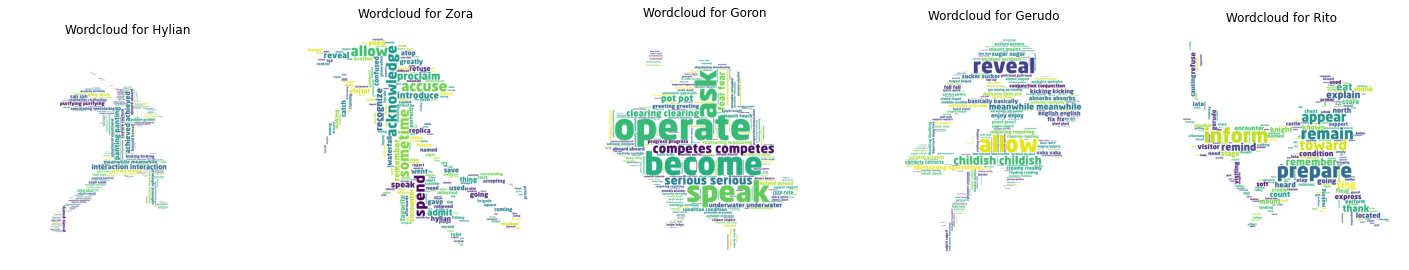

In [8]:
# Generating wordclouds

race_order  = [
    "Hylian", 
    "Zora", 
    "Goron", 
    "Gerudo", 
    "Rito"
]

rows = 1
cols = 5
cloud_size = 1000


fig, axs = plt.subplots(rows, cols, figsize=(25, 5))
for ax, race in tqdm(zip(axs.flatten(), race_order), total=5):
    race_df = races[race]["pd"]
    
    # Repeat each word int(IDF)-number of times
    words = [[x.Term] * int(x.IDF) for x in race_df.itertuples()] 

    # Flatten the list of lists
    flattened_words = [item for subl in words for item in subl] 

    # Join all the words
    joined_words = " ".join(flattened_words) 

    mask = plt.imread(f"./images/{race}.jpg")

    wcloud = wordcloud.WordCloud(
        background_color="white",
        width=cloud_size,
        height=cloud_size,
        mask=mask,
        font_path="./NeoSans Black.otf"
    ).generate(joined_words)

    ax.imshow(wcloud)
    ax.axis("off")
    ax.set_title(f"Wordcloud for {race}")
plt.savefig("./images/wordcloud.jpg", dpi=300)
plt.show()

# Results of the wordclouds


# 3. Communities and TF-IDF

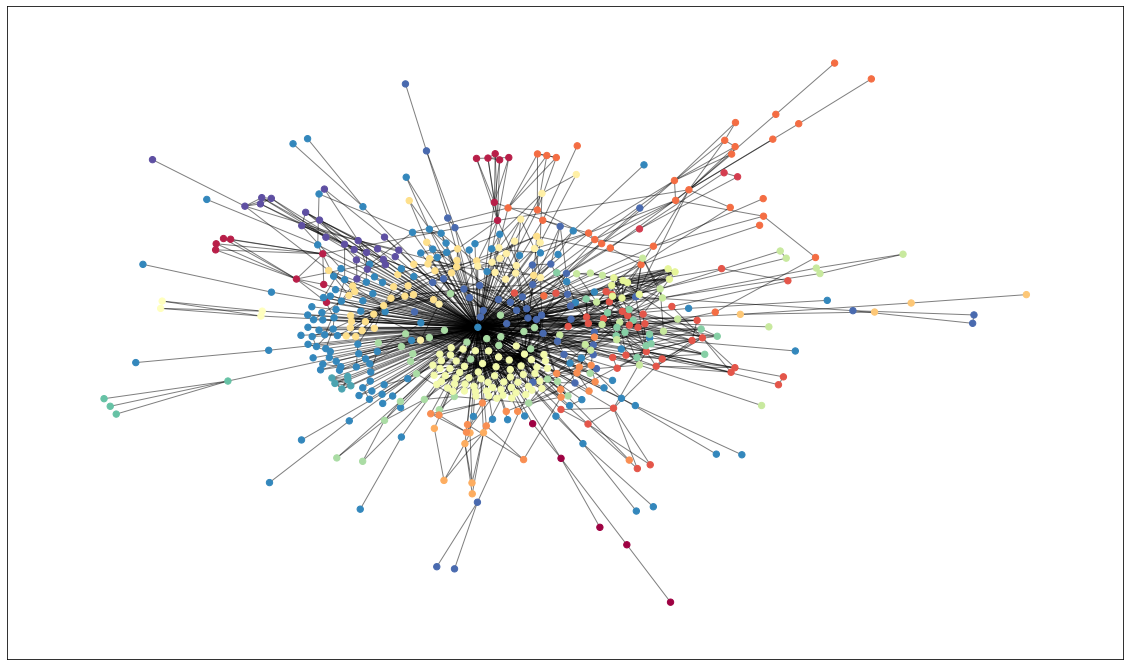

In [9]:
# Transforming GCC to non-directed graph
UGCC = GCC.to_undirected()

partition = community.best_partition(UGCC)

plt.figure(figsize=(20, 12))

pos = nx.spring_layout(UGCC)
# color the nodes according to their partition
# cmap = matplotlib.colors.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(UGCC, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(UGCC, pos, alpha=0.5)
plt.show()


In [10]:
def construct_communities(partition, G):

  communities = dict()

  for node_name in G.nodes():
    key = partition[node_name]
    communities[key] = communities.get(key, [])
    communities[key].append(node_name)
  
  return communities

def modularity(communities, graph):
  modularity = 0
  for com in communities:
    Lc = len(graph.edges(communities[com]))
    L = len(graph.edges)
    kc = sum(x[1] for x in list(graph.degree(communities[com])))
    
    modularity += Lc/L - (kc/(2*L))**2
  return modularity

communities = construct_communities(partition, UGCC)
mod = modularity(communities, UGCC)

# Setting the dictionary keys to top3 names, as specified in exercise
for key, community in dict(communities).items():
  top3 = sorted([name for name in community], key = lambda x: UGCC.degree(x), reverse=True)[:3]
  names = "_".join([x.replace(" ", "-") for x in top3])

  # Adding top3 as new name, and deleting previous key
  communities[names] = community
  del communities[key]

print("Number of communities:", len(set(partition.values())))
print("Modularity:", mod)

Number of communities: 21
Modularity: 1.2035022830382684


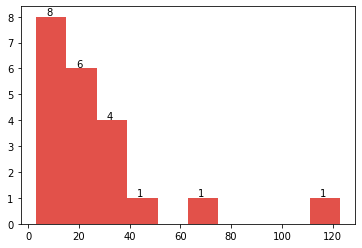

In [11]:
counts, bins, bars = plt.hist([len(x) for x in communities.values()])
for c, b in zip(counts, bins):
    if c > 0: plt.text(b+4, c+.05, f"{c:.0f}")
plt.show() # Fix colors

In [12]:
sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)
largest = sorted_communities[:5]

tfidf_coms = {}
for (key, names) in largest:
    filenames = [name + ".txt" for name in names]
    wlist = nltk.corpus.PlaintextCorpusReader(processed_path, filenames)

    terms = set(wlist.words())

    text = nltk.Text(wlist.words())
    tfs = [[term, TF(term, text)] for term in terms]
    tdf = pd.DataFrame(tfs, columns=["Term", "TF"])
    idf = IDF(terms, wlist)

    temp_df = pd.merge(tdf, idf, on="Term")
    temp_df["TFIDF"] = temp_df.TF * temp_df.IDF

    tfidf_coms[key] = temp_df

In [13]:
print("Top 5 according to TF")
for community, frame in tfidf_coms.items():
    print("Community:", community)
    display(frame.sort_values(by="TF", ascending=False).head(5)[["Term", "TF"]].style.hide_index())
    print()

Top 5 according to TF
Community: Link_Vilia_Canni


Term,TF
gerudo,0.014134
horse,0.009649
wild,0.008658
stable,0.008449
tell,0.007354



Community: Calamity-Ganon_Hylia_Kah-Mael


Term,TF
shrine,0.065969
monk,0.040541
sheikah,0.034002
calamity,0.020198
breath,0.018454



Community: Princess-Zelda_Purah_Impa


Term,TF
zelda,0.027098
ganon,0.011910
princess,0.010638
hyrule,0.009166
time,0.007494



Community: Bokoblin_Moblin_Lynel


Term,TF
moblins,0.014519
bokoblins,0.014264
-,0.012481
blue,0.009424
lynels,0.008660



Community: Riju_Traysi_Barta


Term,TF
gerudo,0.036040
town,0.018465
speaks,0.012236
say,0.011568
tell,0.010901


In [14]:
print("Top 5 according to TF-IDF")
for community, frame in tfidf_coms.items():
    print("Community:", community)
    display(frame.sort_values(by="TFIDF", ascending=False).head(5)[["Term", "TFIDF"]].style.hide_index())
    print()

Top 5 according to TF-IDF
Community: Link_Vilia_Canni


Term,TFIDF
horse,0.026000
zelda,0.025228
gerudo,0.022403
sword,0.020314
seal,0.014394



Community: Calamity-Ganon_Hylia_Kah-Mael


Term,TFIDF
zelda,0.020250
maag,0.015318
would,0.013897
hero,0.013018
demise,0.012160



Community: Princess-Zelda_Purah_Impa


Term,TFIDF
zelda,0.034567
princess,0.025039
ganon,0.015192
hyrule,0.012408
triforce,0.012106



Community: Bokoblin_Moblin_Lynel


Term,TFIDF
moblins,0.031504
lynels,0.022386
old,0.018436
bokoblins,0.016688
-,0.013510



Community: Riju_Traysi_Barta


Term,TFIDF
volume,0.018109
stable,0.012467
tell,0.010901
naboris,0.010679
beast,0.010645


# 4. Sentiment of communities
First we do the sentiment analysis of characters. This is done in the LabMT and Vader section. Then we look at the histograms, happiest and saddest characters, and the community analysis.

## LabMT

In [15]:
dialogue = json.loads(open("Dialogue/CharactersDialogue.json", "r").read())
pretty_dialogue = {}

wnl = nltk.WordNetLemmatizer()
wpt = nltk.WordPunctTokenizer()

# We're not removing punctuation, as if the symbol, is not present
# in LabMT, we will not score it.
for name, word_list in dialogue.items():
    lemmatized = wnl.lemmatize(" ".join(word_list))
    lower = lemmatized.lower()
    tokens = wpt.tokenize(lower)
    pretty_dialogue[name] = tokens

In [22]:
# Sentimenting
LabMT = pd.read_csv("./Wordlist/pone.0026752.s001.txt", delimiter="\t", skiprows=3)
LabMT_sentiments = {}

lab_sentiments = {}
for name, tokens in tqdm(pretty_dialogue.items()):
    freq = nltk.FreqDist(tokens)
    nominator, denominator = 0, 0

    for word in freq.keys():
        if word in LabMT.word.values:
            fk = freq.get(word)
            vk = LabMT[LabMT.word == word].happiness_average.values[0]

            nominator += vk * fk
            denominator += fk
    
    if denominator > 0:
        lab_sentiments[name] = nominator/denominator

100%|██████████| 475/475 [00:52<00:00,  9.09it/s]


## VADER

In [17]:
VADER = SentimentIntensityAnalyzer()
VADER_sentiments = {}
for name, tokens in tqdm(dialogue.items()):
    VADER_sentiments[name] = VADER.polarity_scores(tokens)

100%|██████████| 475/475 [00:05<00:00, 81.35it/s]


# Analysis of characters
First we show the histograms, then the top 10 happiest and saddest according to LabMT and Vader

(array([ 20.,   7.,   7.,   2.,   5.,   0.,   1.,   5.,  33., 395.]),
 array([-0.996  , -0.79641, -0.59682, -0.39723, -0.19764,  0.00195,
         0.20154,  0.40113,  0.60072,  0.80031,  0.9999 ]),
 <BarContainer object of 10 artists>)

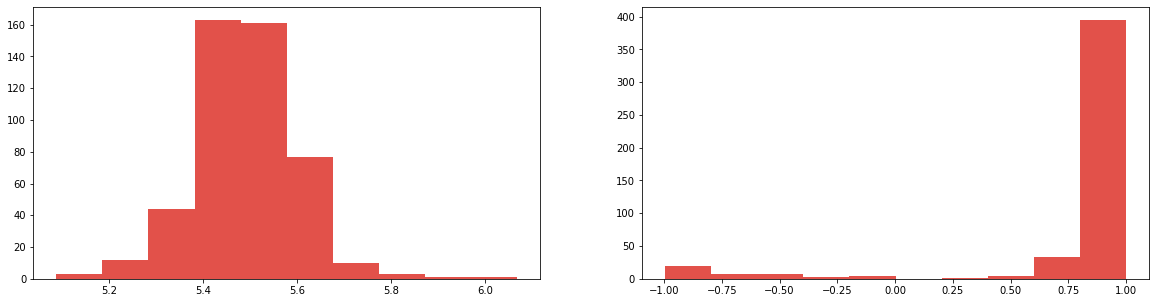

In [34]:
# Histogram
fig, (lab, vad) = plt.subplots(1, 2, **default)

lab.hist(lab_sentiments.values())
vad.hist([x["compound"] for x in VADER_sentiments.values()])

In [57]:
# Top 10
lab_sentiment_sorted = sorted(lab_sentiments.items(), key=lambda x: x[1], reverse=True)
vader_compound_sorted = sorted(VADER_sentiments.items(), key=lambda x: x[1]["compound"], reverse=True)

num = 10

print("Happiest lab:\n", "\n ".join([str(x) + ": " + str(y) for x, y in lab_sentiment_sorted[:num]])) # Happiest lab
print("\nSaddest lab:\n", "\n ".join([str(x) + ": " + str(y) for x, y in lab_sentiment_sorted[-num:]])) # Saddest lab
print("\nHappiest vader:\n", "\n ".join([str(x) + ": " + str(y["compound"]) for x, y in vader_compound_sorted[:num]])) # 
print("\nSaddest vader:\n", "\n ".join([str(x) + ": " + str(y["compound"]) for x, y in vader_compound_sorted[-num:]]))


Happiest lab:
 Zooki: 6.068571428571429
 Kinov: 5.966666666666668
 Narah: 5.837431192660549
 Tasho: 5.8296
 Shamae: 5.808235294117649
 Kula: 5.765384615384615
 Toren: 5.737701149425289
 Chessica: 5.733129770992369
 Notts: 5.703015873015873
 Kayden: 5.69268221574344

Saddest lab:
 Laine: 5.247499999999999
 Sudrey: 5.242743362831858
 Flaxel: 5.237540983606562
 Bargoh: 5.215220588235297
 Palme: 5.200645161290322
 Strade: 5.1944690265486715
 Walton: 5.19
 Kotta: 5.176074074074074
 Kenyo: 5.175593220338983
 Aya: 5.087692307692309

Happiest vader:
 Nazbi: 0.9999
 Lonni: 0.9999
 Paya: 0.9999
 Baddek: 0.9998
 Cambo: 0.9998
 Galli: 0.9998
 Brokka: 0.9998
 Daruk: 0.9997
 Mipha: 0.9997
 Stamm: 0.9997

Saddest vader:
 Russ: -0.9555
 Geggle: -0.9564
 Kaifa: -0.9639
 Hoz: -0.9725
 Kotts: -0.9797
 Kotta: -0.9832
 Strade: -0.9854
 Dayto: -0.9917
 Rik: -0.9941
 Princess Zelda: -0.996


# Analysis of communities

In [79]:
lab_avg_communities = {}
for name, characters in communities.items():
    lab_avg_communities[name] = sum([lab_sentiments[cname] 
                                    for cname in characters 
                                    if cname in lab_sentiments.keys()])/len(characters)
                                    
lab_avg_communities = {name: val for name, val in lab_avg_communities.items() if val != 0.0}

vad_avg_communities = {}
for name, characters in communities.items():
    vad_avg_communities[name] = sum([VADER_sentiments[cname]["compound"] 
                                    for cname in characters 
                                    if cname in VADER_sentiments.keys()])/len(characters)

vad_avg_communities = {name: val for name, val in vad_avg_communities.items() if val != 0.0}

In [80]:
# 3 Happiest
print("Happiest communities LabMT")
print("\n".join([str(x) + ": " + str(y) for x, y in sorted(lab_avg_communities.items(), key = lambda x: x[1], reverse=True)[:3]]))

print()
print("Happiest communities Vader")
print("\n".join([str(x) + ": " + str(y) for x, y in sorted(vad_avg_communities.items(), key = lambda x: x[1], reverse=True)[:3]]))

print()
print("Saddest communities LabMT")
print("\n".join([str(x) + ": " + str(y) for x, y in sorted(lab_avg_communities.items(), key = lambda x: x[1], reverse=True)[-3:]]))

print()
print("Saddest communities Vader")
print("\n".join([str(x) + ": " + str(y) for x, y in sorted(vad_avg_communities.items(), key = lambda x: x[1], reverse=True)[-3:]]))

Happiest communities LabMT
Amira_Azu_Nikki: 5.51525126652361
Anly_Cima_Kampo: 5.490552652712953
Olkin_Steen_Rik: 5.4754096373654395

Happiest communities Vader
Ashai_Pearle_Rotana: 0.8546391304347827
Amira_Azu_Nikki: 0.8538777777777777
Link_Vilia_Canni: 0.8272731707317071

Saddest communities LabMT
Kilton_Stone-Talus_Igneo-Talus: 1.9040776647149713
Monkton_Harry-(Breath-of-the-Wild)_Mary-(Breath-of-the-Wild): 1.7767359050445102
Fire-Wizzrobe_Electric-Wizzrobe_Fire-Keese: 0.3629966397849463

Saddest communities Vader
Bokoblin_Moblin_Lynel: 0.2521083333333334
Fire-Wizzrobe_Electric-Wizzrobe_Fire-Keese: 0.06658666666666667
Monkton_Harry-(Breath-of-the-Wild)_Mary-(Breath-of-the-Wild): -0.05756666666666666


In [161]:
lab_std = {}

lab_std = {name: (sum([(lab_sentiments[cname] - lab_avg_communities[name])**2 
                        for cname in characters 
                        if cname in lab_sentiments.keys()])/len(characters))**.5
                        for name, characters in communities.items()
                        if name in lab_avg_communities.keys()}
                        
vad_std = {name: (sum([(VADER_sentiments[cname]["compound"] - vad_avg_communities[name])**2 
                        for cname in characters 
                        if cname in VADER_sentiments.keys()])/len(characters))**.5
                        for name, characters in communities.items()
                        if name in vad_avg_communities.keys()}

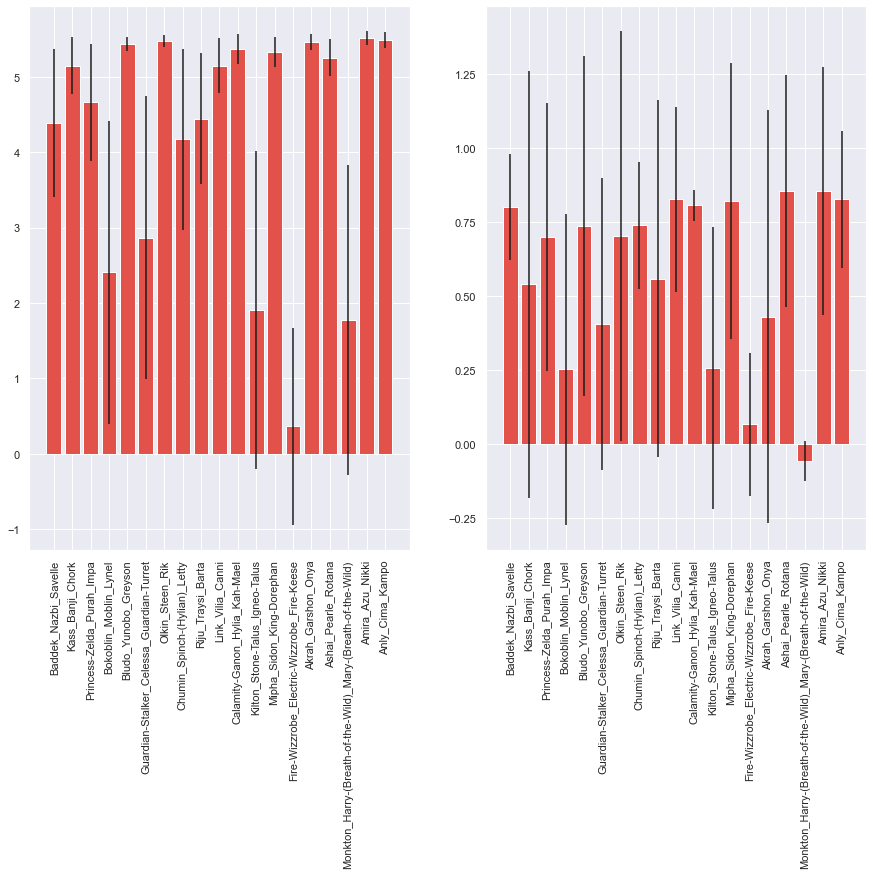

In [166]:
fig, (lab, vad) = plt.subplots(1, 2, figsize=(15, 10))

lab.bar(lab_avg_communities.keys(), lab_avg_communities.values(), yerr=lab_std.values())
for tick in lab.get_xticklabels():
    tick.set_rotation(90)

vad.bar(vad_avg_communities.keys(), vad_avg_communities.values(), yerr=vad_std.values())
for tick in vad.get_xticklabels():
    tick.set_rotation(90)